<a href="https://colab.research.google.com/github/jaejun-yoo/precision_recall/blob/master/analytic_vs_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install munch
import itertools
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics

import munch

def mch(**kwargs):
    return munch.Munch(dict(**kwargs))

  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=c5cb25768bc8e559a000c4cad1fddd80de0484eecaf466a4322196346731a581
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [0]:
def _compute_pairwise_distance(data0, data1):
  '''
  args:
    data0: np.array of num_samples x dimension
    data1: np.array of num_samples x dimension
  returns:
    num_samples x num_samples np.array of pairwise euclidean distances
  '''
  dists = metrics.pairwise_distances(data0, data1, metric ='euclidean', n_jobs=8)
  return dists


def _compute_nearest_k_distances(data, nearest_k):
  '''
  args:
    data0: np.array of num_samples x dimension
    nearest_k: int
  returns:
    np.array of num_samples of float distance values
  '''
  self_distances = _compute_pairwise_distance(data, data)
  kth_distances = np.sort(self_distances, axis=1)[:, nearest_k]
  return kth_distances


class DataMetric(object):
  def __init__(self, config):
    self.config = config
    self.real, self.fake = self._load_iid_gaussians()
    self.distance = _compute_pairwise_distance(self.real, self.fake)
    self.real_kth_radii = _compute_nearest_k_distances(
        self.real, self.config.nearest_k)
    self.fake_kth_radii = _compute_nearest_k_distances(
        self.fake, self.config.nearest_k)

  def _load_iid_gaussians(self, mu=0, sigma=1):
    return (np.random.normal(mu, sigma,
                             (self.config.num_real, self.config.dimension)),
            np.random.normal(mu, sigma,
                             (self.config.num_fake, self.config.dimension)))
    
  def compute_density(self):
    count = (self.distance < 
             np.expand_dims(
                 self.real_kth_radii, 1)).sum()
    return float(count) / self.config.num_fake / self.config.nearest_k

  def compute_coverage(self):
    return (self.distance.min(axis=1) < self.real_kth_radii).mean()


class MetricComputer(object):
  def __init__(self):
    self._data = None
    self._config = None

  def set_data(self, config):
    self._data = DataMetric(config)
    self._config = config

  def compute(self, what):
    if self._data is None or self._config is None:
      raise RuntimeError("First set data.")
    if what == 'density':
      return self._data.compute_density()
    if what == 'coverage':
      return self._data.compute_coverage()
    raise ValueError("Unknown metric type {}.".format(what))


class Analytic(object):
  def __init__(self):
    self._pred_funcs = {
        'density': lambda n, m, k, d: 1,
        'coverage': lambda n, m, k, d: 1-(1-float(k)/n)**m,
    }

  def compute_preds(self, metric, data):
    n, m, k, d = data
    return self._pred_funcs[metric](n, m, k, d)


class TestSuite(object):
  def __init__(self, configs, metric_names):
    self._configs = configs
    self._metric_names = metric_names
    self._metric_computer = MetricComputer()

    self._iterable_key, self._config_list = self._generate_config_list()
    self._analytic = Analytic()

    self._x_values = self._configs[self._iterable_key]
    self._y_values = mch(**{metric: [] for metric in metric_names})

  def _generate_config_list(self):
    config_list = []
    keys = sorted(list(self._configs.keys()))
    values_list = []

    count_iterables = 0
    iterable_key = None
    for ky in keys:
      try:
        iter(self._configs[ky])
        values_list.append(self._configs[ky])
        count_iterables += 1
        iterable_key = ky
      except TypeError:
        self._configs[ky] = [self._configs[ky]]
        values_list.append(self._configs[ky])

    if count_iterables != 1:
      raise ValueError("Configs must contain 1 iterable.")

    for items in itertools.product(*values_list):
      config_list.append(mch(**dict(zip(keys, items))))

    return iterable_key, config_list

  def test(self):
    for config in self._config_list:
      print(config)
      self._metric_computer.set_data(config)
      for metric in self._metric_names:
        result = self._metric_computer.compute(metric)
        self._y_values[metric].append(result)

  def _compute_analytic_pred_array(self, metric):
    analytic_y_values = []
    for config in self._config_list:
      n = config.num_real
      m = config.num_fake
      k = config.nearest_k
      d = config.dimension
      pred = self._analytic.compute_preds(metric, (n, m, k, d))
      analytic_y_values.append(pred)
    return np.array(analytic_y_values)

  def plot(self):
    for metric in self._metric_names:
      plt.plot(self._x_values, self._y_values[metric], label='simulation')
      analytic_prediction = self._compute_analytic_pred_array(metric)
      plt.plot(self._x_values, analytic_prediction, label='analytic')
      plt.legend()
      plt.grid(True)
      plt.xlabel(self._iterable_key)
      plt.ylabel(metric)
      plt.show()


Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 10})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 12})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 16})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 20})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 26})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 33})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 42})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 54})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 69})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 88})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 112})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 143})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 183})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake

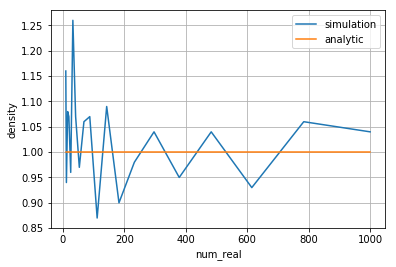

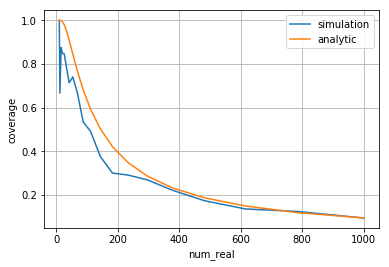

In [0]:
configs = mch(
    num_real=np.logspace(1, 3, 20,dtype=np.int),
    num_fake=100,
    nearest_k=1,
    dimension=1,
)
metric_names = ['density', 'coverage']

test_suite = TestSuite(configs, metric_names)
test_suite.test()
test_suite.plot()

Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 10, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 10, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 10, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 11, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 12, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 12, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 13, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 13, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 14, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 15, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 15, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 16, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 17, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 

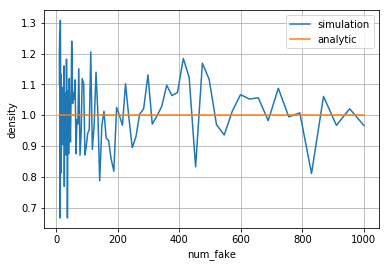

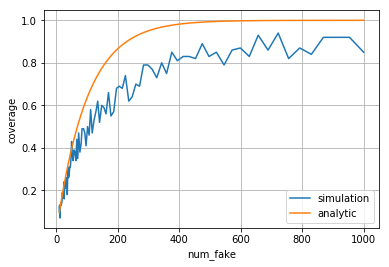

In [0]:
configs = mch(
    num_real=100,
    num_fake=np.logspace(1, 3, 100,dtype=np.int),
    nearest_k=1,
    dimension=1,
)
metric_names = ['density', 'coverage']

test_suite = TestSuite(configs, metric_names)
test_suite.test()
test_suite.plot()

Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 2, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 2, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 1, 'nearest_k': 2,

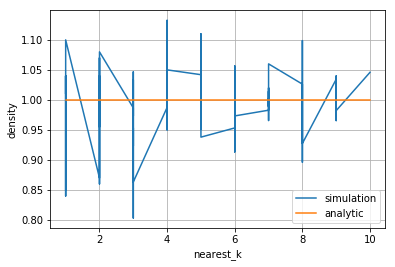

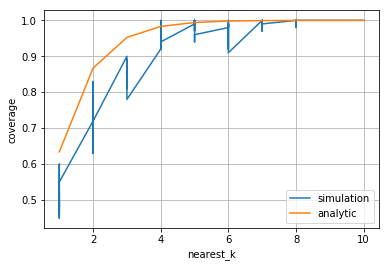

In [0]:
configs = mch(
    num_real=100,
    num_fake=100,
    nearest_k=np.linspace(1,10,100,dtype=np.int),
    dimension=1,
)
metric_names = ['density', 'coverage']

test_suite = TestSuite(configs, metric_names)
test_suite.test()
test_suite.plot()

Munch({'dimension': 10, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 12, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 16, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 20, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 26, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 33, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 42, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 54, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 69, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 88, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 112, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 143, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 183, 'nearest_k': 1, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 23

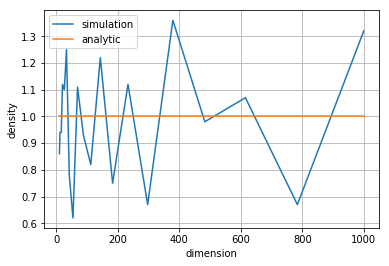

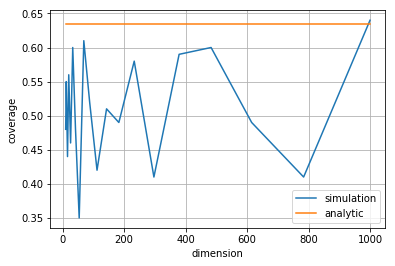

In [0]:
configs = mch(
    num_real=100,
    num_fake=100,
    nearest_k=1,
    dimension=np.logspace(1,3,20,dtype=np.int),
)
metric_names = ['density', 'coverage']

test_suite = TestSuite(configs, metric_names)
test_suite.test()
test_suite.plot()

Munch({'dimension': 10, 'nearest_k': 5, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 12, 'nearest_k': 5, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 16, 'nearest_k': 5, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 20, 'nearest_k': 5, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 26, 'nearest_k': 5, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 33, 'nearest_k': 5, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 42, 'nearest_k': 5, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 54, 'nearest_k': 5, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 69, 'nearest_k': 5, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 88, 'nearest_k': 5, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 112, 'nearest_k': 5, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 143, 'nearest_k': 5, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 183, 'nearest_k': 5, 'num_fake': 100, 'num_real': 100})
Munch({'dimension': 23

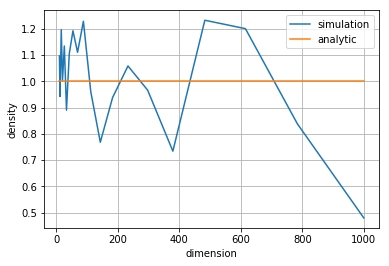

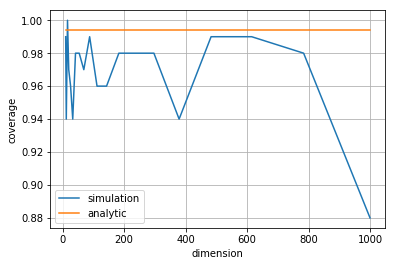

In [0]:
configs = mch(
    num_real=100,
    num_fake=100,
    nearest_k=5,
    dimension=np.logspace(1,3,20,dtype=np.int),
)
metric_names = ['density', 'coverage']

test_suite = TestSuite(configs, metric_names)
test_suite.test()
test_suite.plot()